In this Notebook, Machine Learning (ML) models will be performed on Log Returns transformation along with the different scaling techniques. 



Different models are being applied because each one presents different strenghts, models that can capture linear and non-linear relationships, seasonalities. And ultimately compare the peformance scores to indicate which model would the best fit for the data. 
  
**Note**: Rationale for MLs will be written in the Log_Returns ML Notebook and not in the Seasonal Differencing to avoid repetition.

# IF STARTS TO GET CONFUSING OR TOO SLOW APPLY OTHERS IN DIFFERENT NOTEBOOKS. 

In [2]:
# Importing libraries for the project.
import pandas as pd
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import RobustScaler, PowerTransformer, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam
import optuna

import warnings # filter warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing the dataset after the Log Returns transformation.
df = pd.read_csv('df_log.csv', index_col=0, parse_dates=True)

# Along with the importation, the code will set the date as the index, value of 0 because is the first column.
## Setting parse_dates=true to ensure the dates are in datetime, making more appropriate for ML models.   

In [4]:
df.head()

,Close,Year
Date,,
2014-01-01,0.000000,2014
2014-01-02,-0.008901,2014
2014-01-03,-0.000333,2014
2014-01-06,-0.002515,2014
2014-01-07,0.006063,2014


In [5]:
# Ensures that the index is sorted.
df = df.sort_index()

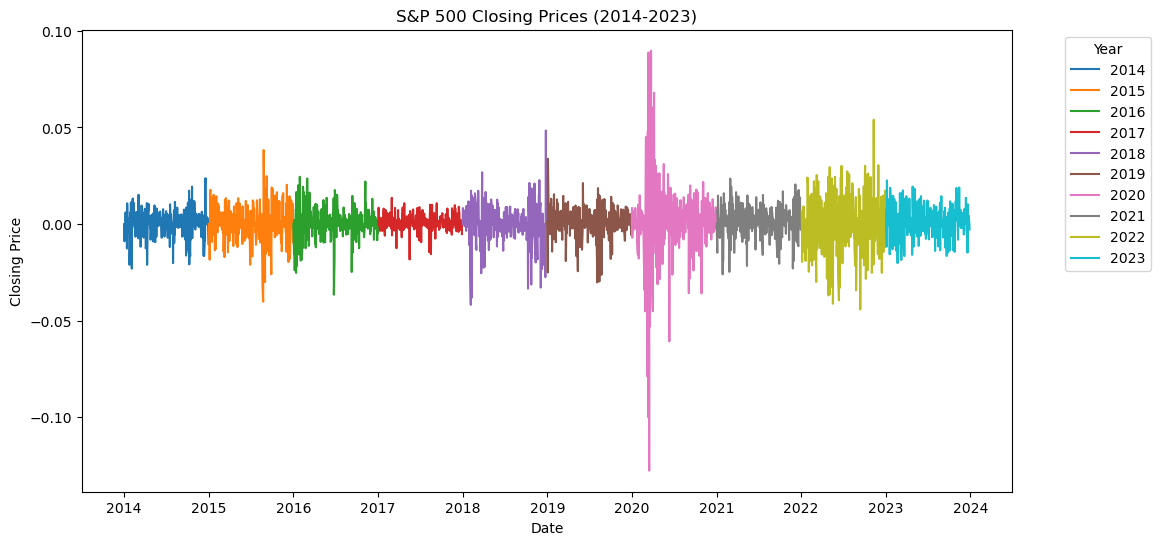

In [6]:
# Line Plot per Year
plt.figure(figsize=(12, 6)) # Sets fig size.
# Sets  the lineplot where the colors are based on the year, following the tab10 palette, providing clarity to the observer. 
sns.lineplot(data=df, x=df.index, y='Close', hue='Year', palette='tab10') 
plt.title('S&P 500 Closing Prices (2014-2023)') # Sets title.
plt.xlabel('Date') # Add label.
plt.ylabel('Closing Price') # Add label.
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left') # Adds legend (years) and configures it. 
plt.show() # Display the fig. 

# Forecasting Models. 

To start, the data will be splited into train and test sets, with the selected ratio of 90%-10%. There are 10 years worth of data, thus the test set will start from 01-01-23 to 31-12-23 and the train would be composed by the data prior to 2023.

**Note**: Stage where different split ratios could be tested depending on the time available. 

In [8]:
# Extracting the total size, based on the length of the series.
total_size = len(df)

# Calculates indices for the 80-10-10 split.
train_size = int(total_size * 0.80) # 80%.
val_size = int(total_size * 0.10) # 10%.
test_size = total_size - train_size - val_size  # The remaining 10%. 

# Performing the splits.
train = df.iloc[:train_size]  # First 80% of the data.
val = df.iloc[train_size:train_size + val_size]  # Next 10% of the data.
test = df.iloc[train_size + val_size:]  # Final 10% of the data.

In [9]:
display(train, val, test)

,Close,Year
Date,,
2014-01-01,0.000000,2014
2014-01-02,-0.008901,2014
2014-01-03,-0.000333,2014
2014-01-06,-0.002515,2014
2014-01-07,0.006063,2014
...,...,...
2021-12-23,0.006204,2021
2021-12-24,0.000000,2021
2021-12-27,0.013744,2021


,Close,Year
Date,,
2021-12-30,-0.002994,2021
2021-12-31,-0.002630,2021
2022-01-03,0.006354,2022
2022-01-04,-0.000630,2022
2022-01-05,-0.019583,2022
...,...,...
2022-12-22,-0.014557,2022
2022-12-23,0.005851,2022
2022-12-26,0.000000,2022


,Close,Year
Date,,
2022-12-29,0.017311,2022
2022-12-30,-0.002544,2022
2023-01-02,0.000000,2023
2023-01-03,-0.004009,2023
2023-01-04,0.007511,2023
...,...,...
2023-12-25,0.000000,2023
2023-12-26,0.004223,2023
2023-12-27,0.001429,2023


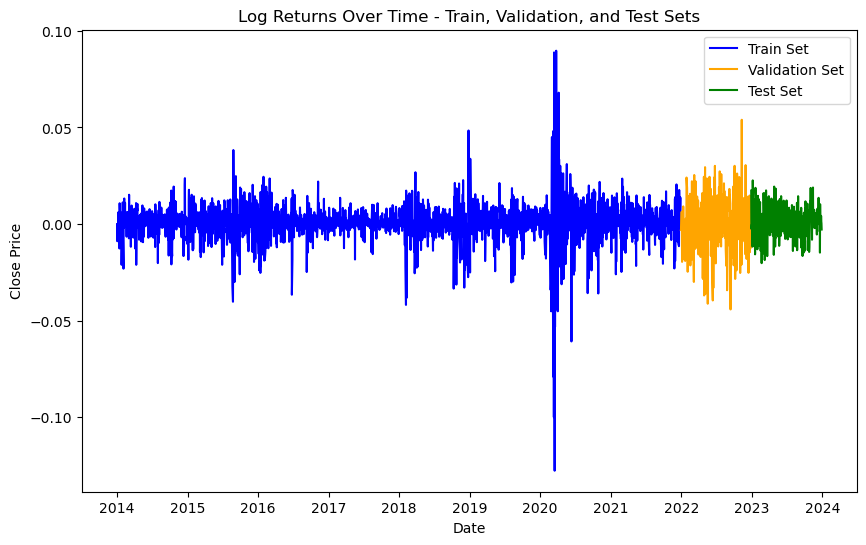

In [10]:
# Creates lineplot indicating the timeframe for each set. 
plt.figure(figsize=(10,6))

# Plot the training set in blue
plt.plot(train.index, train['Close'], label='Train Set', color='blue')

# Plot the validation set in orange
plt.plot(val.index, val['Close'], label='Validation Set', color='orange')

# Plot the test set in green
plt.plot(test.index, test['Close'], label='Test Set', color='green')

# Adding title and labels
plt.title('Log Returns Over Time - Train, Validation, and Test Sets')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Add a legend to differentiate the sets
plt.legend()

# Display the plot
plt.show()

In [11]:
# Initializes the Robust Scaler.
robust_scaler = RobustScaler()

# Fit and transforms the log Returns (train set).
train['Close_Robust_Scaled'] = robust_scaler.fit_transform(train[['Close']])

# Fit and transforms the log Returns (validation set).
val['Close_Robust_Scaled'] = robust_scaler.transform(val[['Close']])

# Fit and transforms the log Returns (test set).
test['Close_Robust_Scaled'] = robust_scaler.transform(test[['Close']])

In [12]:
# Initialize the Power Scaler with yeo-johnson method.
power_scaler = PowerTransformer(method='yeo-johnson')

# Fit and transforms the log Returns (Close) column.
train['Close_Power_Scaled'] = power_scaler.fit_transform(train[['Close']])

# Fit and transforms the log Returns (validation set).
val['Close_Power_Scaled'] = power_scaler.transform(val[['Close']])

# Fit and transforms the log Returns (Close) column.
test['Close_Power_Scaled'] = power_scaler.transform(test[['Close']])

In [13]:
# Initializes the Min-Max Scaler.
min_max_scaler = MinMaxScaler()

# Fit and transforms the log Returns (Close) column.
train['Close_MinMax_Scaled'] = min_max_scaler.fit_transform(train[['Close']])

# Fit and transforms the log Returns (validation set).
val['Close_MinMax_Scaled'] = min_max_scaler.transform(val[['Close']])

# Fit and transforms the log Returns (Close) column.
test['Close_MinMax_Scaled'] = min_max_scaler.transform(test[['Close']])

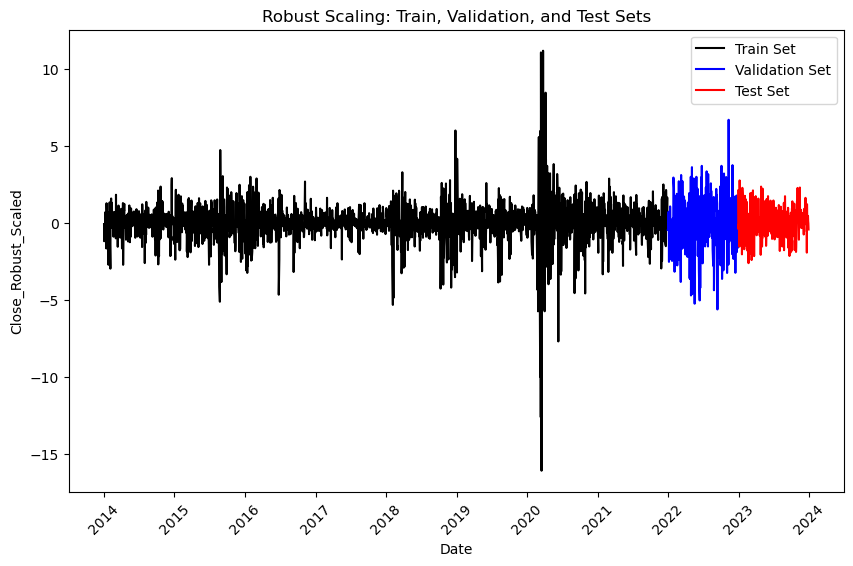

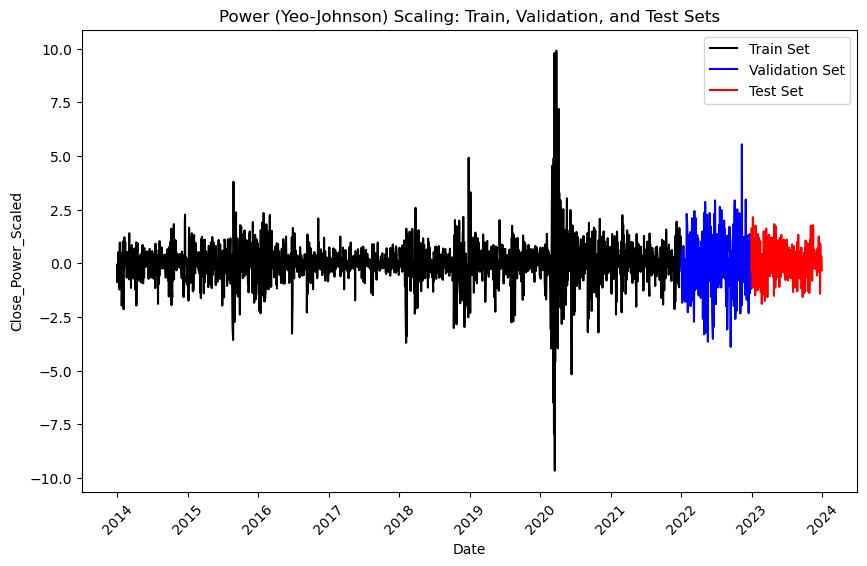

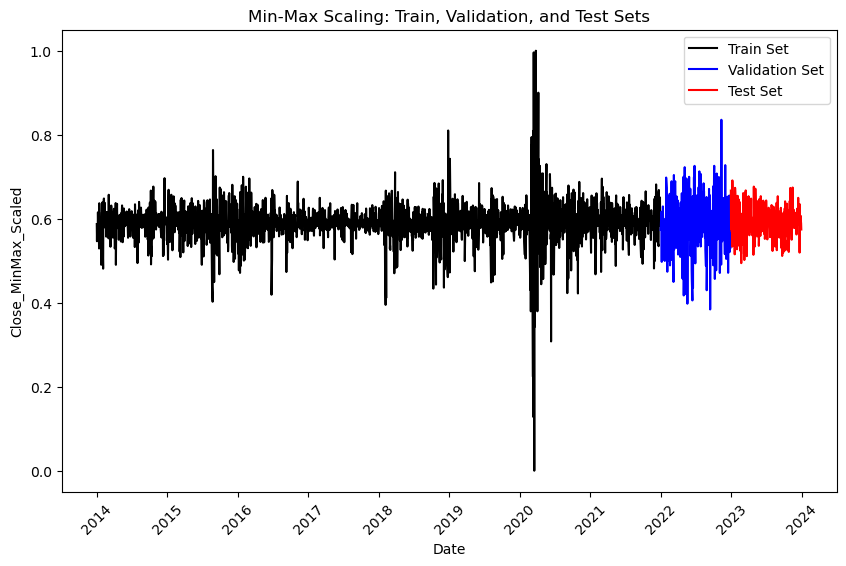

In [14]:
# Defines a function to plot the scaled data for train, validation, and test sets.
def plot_scaled_data(train, val, test, column_name, scale_type):
    plt.figure(figsize=(10,6))
    
    # Plot the training data.
    plt.plot(train.index, train[column_name], label='Train Set', color='black')
    
    # Plot the validation data.
    plt.plot(val.index, val[column_name], label='Validation Set', color='blue')
    
    # Plot the test data.
    plt.plot(test.index, test[column_name], label='Test Set', color='red')
    
    # Adding title and labels.
    plt.title(f'{scale_type} Scaling: Train, Validation, and Test Sets')
    plt.xlabel('Date')
    plt.ylabel(f'{column_name}')
    plt.xticks(rotation=45)
    
    # Show the legend.
    plt.legend()
    
    # Display the plot.
    plt.show()

# Plot for Robust Scaled Data.
plot_scaled_data(train, val, test, 'Close_Robust_Scaled', 'Robust')

# Plot for Power Scaled Data.
plot_scaled_data(train, val, test, 'Close_Power_Scaled', 'Power (Yeo-Johnson)')

# Plot for Min-Max Scaled Data.
plot_scaled_data(train, val, test, 'Close_MinMax_Scaled', 'Min-Max')

## Neural Networks 



### Close_Robust_Scaled

In [17]:
train_robust = train["Close_Robust_Scaled"].values
type(train_robust)

numpy.ndarray

In [18]:
x_train_robust = []

y_train_robust = []

In [19]:
for i in range(21, len(train_robust)):
    x_train_robust.append(train_robust[i-21:i])
    y_train_robust.append(train_robust[i])

In [20]:
x_train_robust = np.array(x_train_robust)
y_train_robust = np.array(y_train_robust)

print(x_train_robust.shape)
print(y_train_robust.shape)

(2065, 21)
(2065,)


In [21]:
x_train_robust = np.reshape(x_train_robust, (x_train_robust.shape[0], 

                                               x_train_robust.shape[1], 

                                               1))

print(x_train_robust.shape)

(2065, 21, 1)


In [22]:
rnn = Sequential()

rnn.add(LSTM(units = 45, return_sequences = True, input_shape = (21, 1)))

rnn.add(Dropout(0.2))

rnn.add(LSTM(units = 45, return_sequences = True))

rnn.add(Dropout(0.2))

rnn.add(LSTM(units = 45, return_sequences = True))

rnn.add(Dropout(0.2))

rnn.add(LSTM(units = 45))

rnn.add(Dropout(0.2))

rnn.add(Dense(units = 1))

rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')

rnn.fit(x_train_robust, y_train_robust, epochs = 100, batch_size = 32)

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 1.9165
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 2.0770
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 1.6623
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 1.9298
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1.8174
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1.7190
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 1.7502
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 1.9685
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 1.6482
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.8056
Epoch 11/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6530
Epoch 12/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.0470
Epoch 13/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2089
Epoch 14/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7158
Epoch 15/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - l

#### Random Search - Hyperparameter Tunning


#### Bayesian Optimization - Optuna 



In [25]:
# Validation set.
val_robust = val["Close_Robust_Scaled"].values
x_val_robust, y_val_robust = [], []
for i in range(21, len(val_robust)):
    x_val_robust.append(val_robust[i-21:i])
    y_val_robust.append(val_robust[i])
x_val_robust = np.array(x_val_robust)
y_val_robust = np.array(y_val_robust)
x_val_robust = np.reshape(x_val_robust, (x_val_robust.shape[0], x_val_robust.shape[1], 1))

# Prints the shape of the validation sets. 
print(x_val_robust.shape)
print(y_val_robust.shape)

# Test set (if you want to apply the same logic for testing)
test_robust = test["Close_Robust_Scaled"].values
x_test_robust, y_test_robust = [], []
for i in range(21, len(test_robust)):
    x_test_robust.append(test_robust[i-21:i])
    y_test_robust.append(test_robust[i])
x_test_robust = np.array(x_test_robust)
y_test_robust = np.array(y_test_robust)
x_test_robust = np.reshape(x_test_robust, (x_test_robust.shape[0], x_test_robust.shape[1], 1))# Prints the shape of the validation sets. 
print(x_test_robust.shape)
print(y_test_robust.shape)

(239, 21, 1)
(239,)
(241, 21, 1)
(241,)


In [26]:
# Define an objective function for Optuna, including a variable number of LSTM layers
def objective(trial):
    # Suggest the number of layers (1 to 4)
    num_layers = trial.suggest_int('num_layers', 1, 4)
    
    # Suggest the number of units in LSTM layers
    units = trial.suggest_int('units', 32, 128, step=32)
    
    # Suggest dropout rate
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    
    # Suggest learning rate
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

     # Suggest the number of epochs and batch size
    epochs = trial.suggest_int('epochs', 50, 200)  # Range for epochs
    batch_size = trial.suggest_int('batch_size', 16, 128, step=16)  # Range for batch size
    
    # Build the LSTM model dynamically based on the number of layers
    rnn = Sequential()

    # Add the first LSTM layer
    rnn.add(LSTM(units=units, return_sequences=True, input_shape=(x_train_robust.shape[1], 1)))
    rnn.add(Dropout(dropout))

    # Add more LSTM layers based on the number suggested by Optuna
    for i in range(num_layers - 1):  # Subtract 1 since we already added one LSTM layer
        rnn.add(LSTM(units=units, return_sequences=(i < num_layers - 2)))  # Return sequences for all but the last layer
        rnn.add(Dropout(dropout))

    # Add the output layer
    rnn.add(Dense(1))
    
    # Compile the model
    rnn.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Train the model
    history = rnn.fit(x_train_robust, y_train_robust, epochs=epochs, batch_size=batch_size, validation_data=(x_val_robust, y_val_robust), verbose=0)
    
    # Return the validation loss
    return history.history['val_loss'][-1]

# Create an Optuna study object and optimize the objective function
study = optuna.create_study(direction='minimize')  # We want to minimize the validation loss
study.optimize(objective, n_trials=50)  # Try 50 different hyperparameter combinations

# Retrieve the best hyperparameters, including the number of layers
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Build the final model with the best parameters
rnn = Sequential()
rnn.add(LSTM(units=best_params['units'], return_sequences=True, input_shape=(x_train_robust.shape[1], 1)))
rnn.add(Dropout(best_params['dropout']))

# Add the optimal number of LSTM layers
for i in range(best_params['num_layers'] - 1):
    rnn.add(LSTM(units=best_params['units'], return_sequences=(i < best_params['num_layers'] - 2)))
    rnn.add(Dropout(best_params['dropout']))

rnn.add(Dense(1))

# Compile and train the model using the optimal learning rate
rnn.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')
rnn.fit(x_train_robust, y_train_robust, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(x_val_robust, y_val_robust))

[I 2024-10-15 16:24:03,296] A new study created in memory with name: no-name-9bcd322d-d59c-4cee-a167-2c1cd687aa13
[I 2024-10-15 16:25:16,928] Trial 0 finished with value: 3.739130973815918 and parameters: {'num_layers': 3, 'units': 128, 'dropout': 0.4316166227318712, 'learning_rate': 0.00015592110834301365, 'epochs': 89, 'batch_size': 96}. Best is trial 0 with value: 3.739130973815918.
[I 2024-10-15 16:26:05,748] Trial 1 finished with value: 5.165615081787109 and parameters: {'num_layers': 2, 'units': 128, 'dropout': 0.26728106616513614, 'learning_rate': 0.003881188340357927, 'epochs': 90, 'batch_size': 64}. Best is trial 0 with value: 3.739130973815918.
[I 2024-10-15 16:28:14,082] Trial 2 finished with value: 4.785491943359375 and parameters: {'num_layers': 4, 'units': 96, 'dropout': 0.3821838141964916, 'learning_rate': 0.0007171755710879009, 'epochs': 119, 'batch_size': 32}. Best is trial 0 with value: 3.739130973815918.
[I 2024-10-15 16:28:58,062] Trial 3 finished with value: 3.9968

Best hyperparameters: {'num_layers': 1, 'units': 32, 'dropout': 0.2537470651930128, 'learning_rate': 0.00016179215740352217, 'epochs': 176, 'batch_size': 112}
Epoch 1/176
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.6303 - val_loss: 3.2408
Epoch 2/176
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9490 - val_loss: 3.2371
Epoch 3/176
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0387 - val_loss: 3.2362
Epoch 4/176
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7959 - val_loss: 3.2341
Epoch 5/176
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1223 - val_loss: 3.2325
Epoch 6/176
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9733 - val_loss: 3.2324
Epoch 7/176
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7030 - val_loss: 3.2302
Epoch 8/176
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1974 - val_loss: 3.2283
Epoch 9/176
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9112 - val_loss: 3.2262
Epoch 10/176
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6458 - val_lo

In [ ]:
# Define a model-building function for Keras Tuner, including epochs and batch size
def build_model(hp):
    rnn = Sequential()

    # Add the first LSTM layer with a tuned number of units
    rnn.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                 return_sequences=True, input_shape=(x_train_robust.shape[1], 1)))

    # Add the first Dropout layer
    rnn.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # Tune the number of LSTM layers (e.g., 1 to 4 layers)
    for i in range(hp.Int('num_layers', 1, 4)):
        # Add additional LSTM layers based on the chosen number of layers
        rnn.add(LSTM(units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32), 
                     return_sequences=(i < hp.Int('num_layers', 1, 4) - 1)))
        rnn.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    # Add the final Dense layer
    rnn.add(Dense(1))

    # Compile the model with a tuned learning rate
    rnn.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                loss='mean_squared_error')
    
    return rnn

# Instantiate the tuner with the objective of minimizing validation loss
tuner = RandomSearch(
    build_model,
    objective='val_loss',  # Optimize based on validation loss
    max_trials=30,  # Try 30 different hyperparameter combinations
    executions_per_trial=1,  # Number of times to train the model with each combination
    directory='my_dir',
    project_name='lstm_layers_tuning'
)

# Perform the search and tune epochs and batch size inside the search call
tuner.search(x_train_robust, y_train_robust, 
             epochs=100,  # Set fixed number of epochs
             batch_size=32,  # Set fixed batch size
             validation_data=(x_val_robust, y_val_robust))

# Retrieve the best model and hyperparameters
best_model = tuner.get_best_models()[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

# Print the best hyperparameters including the number of layers
print(f"Best hyperparameters: {best_hyperparameters.values}")

# Optionally retrain the best model on the entire dataset
best_model.fit(x_train_robust, y_train_robust, 
               epochs=best_hyperparameters.get('epochs', 100),  # Use the best epochs if tuned
               batch_size=best_hyperparameters.get('batch_size', 32),  # Use the best batch size if tuned
               validation_data=(x_val_robust, y_val_robust))


Trial 17 Complete [00h 01m 31s]
val_loss: 3.583428382873535

Best val_loss So Far: 1.953508734703064
Total elapsed time: 12d 22h 07m 43s

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
64                |32                |units
0.5               |0.2               |dropout
3                 |2                 |num_layers
128               |128               |units_0
0.4               |0.1               |dropout_0
0.0016322         |0.00020142        |learning_rate
32                |96                |units_1
0.1               |0.3               |dropout_1
96                |96                |units_2
0.4               |0.3               |dropout_2
64                |64                |units_3
0.1               |0.3               |dropout_3

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 1.8617 - val_loss: 3.6459
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.6699 - val_loss: 3.5910
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import random

# Set random seeds for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

# Initialize the Sequential model
rnn = Sequential()

# First and only LSTM layer with 96 units, return_sequences=False since this is the last (and only) LSTM layer
rnn.add(LSTM(units=96, return_sequences=False, input_shape=(21, 1)))

# Apply the optimized dropout rate of 0.4000
rnn.add(Dropout(0.4000))

# Final Dense layer for output (1 unit, as it's a regression problem)
rnn.add(Dense(1))

# Compile the model with the optimized learning rate and mean squared error loss
rnn.compile(optimizer=Adam(learning_rate=0.000421), loss='mean_squared_error')

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model with the training data and capture the history object
history1 = rnn.fit(x_train_robust, y_train_robust, 
                  epochs=60, 
                  batch_size=112, 
                  validation_data=(x_val_robust, y_val_robust), 
                  callbacks=[early_stopping], 
                  shuffle=False)  # Shuffle is set to False for time series data


In [ ]:
# Access the history dictionary
print(history1.history.keys())

# Print the loss and validation loss
print("Training Loss:", history1.history['loss'])
print("Validation Loss:", history1.history['val_loss'])

# Plot training & validation loss values
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [60]:
# Access the history dictionary
print(history.history.keys())

# Print the loss and validation loss
print("Training Loss:", history.history['loss'])
print("Validation Loss:", history.history['val_loss'])

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


NameError: name 'history' is not defined

In [ ]:
plt.plot(test_robust)

In [ ]:
predictions = rnn.predict(x_test_robust)

In [ ]:
plt.plot(predictions) 

In [ ]:
plt.plot(predictions, color = 'red', label = "Predictions")

plt.plot(test["Close_Robust_Scaled"].values, color = 'black', label = "Real Data")

plt.title('Log returns Prediction Using Robust Scaler')

plt.legend()

In [ ]:
train_power = train["Close_Power_Scaled"].values
type(train_power)

In [ ]:
x_train_power = []

y_train_power = []

In [ ]:
for i in range(21, len(train_power)):
    x_train_power.append(train_power[i-21:i])
    y_train_power.append(train_power[i])

In [ ]:
x_train_power = np.array(x_train_power)
y_train_power = np.array(y_train_power)

print(x_train_power.shape)
print(y_train_power.shape)

In [ ]:
x_train_power = np.reshape(x_train_power, (x_train_power.shape[0], 

                                               x_train_power.shape[1], 

                                               1))

print(x_train_power.shape)

In [ ]:
rnn = Sequential()

rnn.add(LSTM(units = 45, return_sequences = True, input_shape = (21, 1)))

rnn.add(Dropout(0.2))

rnn.add(LSTM(units = 45, return_sequences = True))

rnn.add(Dropout(0.2))

rnn.add(LSTM(units = 45, return_sequences = True))

rnn.add(Dropout(0.2))

rnn.add(LSTM(units = 45))

rnn.add(Dropout(0.2))

rnn.add(Dense(units = 1))

rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')

rnn.fit(x_train_power, y_train_power, epochs = 100, batch_size = 32)

In [ ]:
test_power = test["Close_Power_Scaled"].values
print(test_power.shape)

In [ ]:
plt.plot(test_power)

In [ ]:
x_test_power = df['Close'][len(df['Close']) - len(test_power) - 21:].values
len(x_test_robust)

In [ ]:
final_x_test_power = []

for i in range(21, len(x_test_power)):

    final_x_test_power.append(x_test_power[i-21:i])

final_x_test_power = np.array(final_x_test_power)

In [ ]:
final_x_test_power = np.reshape(final_x_test_power, (final_x_test_power.shape[0], final_x_test_power.shape[1],1))

In [ ]:
predictions_power = rnn.predict(final_x_test_power)

In [ ]:
plt.plot(predictions_power) 

In [ ]:
unscaled_predictions_power = power_scaler.inverse_transform(predictions_power)

plt.plot(unscaled_predictions_power)

In [ ]:
plt.plot(unscaled_predictions_power, color = 'red', label = "Predictions")

plt.plot(test["Close_Power_Scaled"].values, color = 'black', label = "Real Data")

plt.title('Log returns Prediction Using Power Scaler')

plt.legend()